# **Experimento Self-Optimising Manufacturing in Network (SOMN)**

## **Instalando WandB**
[https://wandb.ai/](https://wandb.ai/)

In [1]:
!pip install wandb -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


**Fazendo login usando minha Api Key**: 1e1748bda3d3df311c1f2248a3dc5d4efea0e752

In [2]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
# tentando login
import wandb
wandb.login()

wandb: Currently logged in as: fredericmferreira (lacmor). Use `wandb login --relogin` to force relogin


True

## **Instalando Stable-Baselines3**
[https://stable-baselines3.readthedocs.io/](https://stable-baselines3.readthedocs.io/)

In [4]:
!pip install "stable-baselines3[extra]>=2.0.0a4" -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 42.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.1 MB/s eta 0:00:00


In [5]:
!pip install git+https://github.com/Stable-Baselines-Team/stable-baselines3-contrib -Uq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## **Agente Proximal Policy Optimization (PPO)**

### **Classe OnPolicyAlgorithm**

In [ ]:
import wandb
import sys
import time
from typing import Any, Dict, List, Optional, Tuple, Type, TypeVar, Union

import numpy as np
import torch as th
from gymnasium import spaces

from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.buffers import DictRolloutBuffer, RolloutBuffer
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import obs_as_tensor, safe_mean
from stable_baselines3.common.vec_env import VecEnv

SelfOnPolicyAlgorithm = TypeVar("SelfOnPolicyAlgorithm", bound="OnPolicyAlgorithm")


class OnPolicyAlgorithm(BaseAlgorithm):
    """
    The base for On-Policy algorithms (ex: A2C/PPO).

    :param policy: The policy model to use (MlpPolicy, CnnPolicy, ...)
    :param env: The environment to learn from (if registered in Gym, can be str)
    :param learning_rate: The learning rate, it can be a function
        of the current progress remaining (from 1 to 0)
    :param n_steps: The number of steps to run for each environment per update
        (i.e. batch size is n_steps * n_env where n_env is number of environment copies running in parallel)
    :param gamma: Discount factor
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator.
        Equivalent to classic advantage when set to 1.
    :param ent_coef: Entropy coefficient for the loss calculation
    :param vf_coef: Value function coefficient for the loss calculation
    :param max_grad_norm: The maximum value for the gradient clipping
    :param use_sde: Whether to use generalized State Dependent Exploration (gSDE)
        instead of action noise exploration (default: False)
    :param sde_sample_freq: Sample a new noise matrix every n steps when using gSDE
        Default: -1 (only sample at the beginning of the rollout)
    :param stats_window_size: Window size for the rollout logging, specifying the number of episodes to average
        the reported success rate, mean episode length, and mean reward over
    :param tensorboard_log: the log location for tensorboard (if None, no logging)
    :param monitor_wrapper: When creating an environment, whether to wrap it
        or not in a Monitor wrapper.
    :param policy_kwargs: additional arguments to be passed to the policy on creation
    :param verbose: Verbosity level: 0 for no output, 1 for info messages (such as device or wrappers used), 2 for
        debug messages
    :param seed: Seed for the pseudo random generators
    :param device: Device (cpu, cuda, ...) on which the code should be run.
        Setting it to auto, the code will be run on the GPU if possible.
    :param _init_setup_model: Whether or not to build the network at the creation of the instance
    :param supported_action_spaces: The action spaces supported by the algorithm.
    """

    rollout_buffer: RolloutBuffer
    policy: ActorCriticPolicy

    def __init__(
        self,
        policy: Union[str, Type[ActorCriticPolicy]],
        env: Union[GymEnv, str],
        learning_rate: Union[float, Schedule],
        n_steps: int,
        gamma: float,
        gae_lambda: float,
        ent_coef: float,
        vf_coef: float,
        max_grad_norm: float,
        use_sde: bool,
        sde_sample_freq: int,
        stats_window_size: int = 100,
        tensorboard_log: Optional[str] = None,
        monitor_wrapper: bool = True,
        policy_kwargs: Optional[Dict[str, Any]] = None,
        verbose: int = 0,
        seed: Optional[int] = None,
        device: Union[th.device, str] = "auto",
        _init_setup_model: bool = True,
        supported_action_spaces: Optional[Tuple[Type[spaces.Space], ...]] = None,
    ):
        super().__init__(
            policy=policy,
            env=env,
            learning_rate=learning_rate,
            policy_kwargs=policy_kwargs,
            verbose=verbose,
            device=device,
            use_sde=use_sde,
            sde_sample_freq=sde_sample_freq,
            support_multi_env=True,
            seed=seed,
            stats_window_size=stats_window_size,
            tensorboard_log=tensorboard_log,
            supported_action_spaces=supported_action_spaces,
        )
        #self.acoes
        self.n_steps = n_steps
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.ent_coef = ent_coef
        self.vf_coef = vf_coef
        self.max_grad_norm = max_grad_norm

        if _init_setup_model:
            self._setup_model()

    def _setup_model(self) -> None:
        self._setup_lr_schedule()
        self.set_random_seed(self.seed)

        buffer_cls = DictRolloutBuffer if isinstance(self.observation_space, spaces.Dict) else RolloutBuffer

        self.rollout_buffer = buffer_cls(
            self.n_steps,
            self.observation_space,
            self.action_space,
            device=self.device,
            gamma=self.gamma,
            gae_lambda=self.gae_lambda,
            n_envs=self.n_envs,
        )
        # pytype:disable=not-instantiable
        self.policy = self.policy_class(  # type: ignore[assignment]
            self.observation_space, self.action_space, self.lr_schedule, use_sde=self.use_sde, **self.policy_kwargs
        )
        # pytype:enable=not-instantiable
        self.policy = self.policy.to(self.device)

    def collect_rollouts(
        self,
        env: VecEnv,
        callback: BaseCallback,
        rollout_buffer: RolloutBuffer,
        n_rollout_steps: int,
    ) -> bool:
        """
        Collect experiences using the current policy and fill a ``RolloutBuffer``.
        The term rollout here refers to the model-free notion and should not
        be used with the concept of rollout used in model-based RL or planning.

        :param env: The training environment
        :param callback: Callback that will be called at each step
            (and at the beginning and end of the rollout)
        :param rollout_buffer: Buffer to fill with rollouts
        :param n_rollout_steps: Number of experiences to collect per environment
        :return: True if function returned with at least `n_rollout_steps`
            collected, False if callback terminated rollout prematurely.
        """
        assert self._last_obs is not None, "No previous observation was provided"
        # Switch to eval mode (this affects batch norm / dropout)
        self.policy.set_training_mode(False)

        n_steps = 0
        rollout_buffer.reset()
        # Sample new weights for the state dependent exploration
        if self.use_sde:
            self.policy.reset_noise(env.num_envs)

        callback.on_rollout_start()

        while n_steps < n_rollout_steps:
            if self.use_sde and self.sde_sample_freq > 0 and n_steps % self.sde_sample_freq == 0:
                # Sample a new noise matrix
                self.policy.reset_noise(env.num_envs)

            with th.no_grad():
                # Convert to pytorch tensor or to TensorDict
                obs_tensor = obs_as_tensor(self._last_obs, self.device)
                actions, values, log_probs = self.policy(obs_tensor)
            actions = actions.cpu().numpy()

            # Rescale and perform action
            clipped_actions = actions
            # Clip the actions to avoid out of bound error
            if isinstance(self.action_space, spaces.Box):
                clipped_actions = np.clip(actions, self.action_space.low, self.action_space.high)

            new_obs, rewards, dones, infos = env.step(clipped_actions)

            self.num_timesteps += env.num_envs

            # Give access to local variables
            callback.update_locals(locals())
            if callback.on_step() is False:
                return False

            self._update_info_buffer(infos)
            n_steps += 1

            if isinstance(self.action_space, spaces.Discrete):
                # Reshape in case of discrete action
                actions = actions.reshape(-1, 1)

            # Handle timeout by bootstraping with value function
            # see GitHub issue #633
            for idx, done in enumerate(dones):
                if (
                    done
                    and infos[idx].get("terminal_observation") is not None
                    and infos[idx].get("TimeLimit.truncated", False)
                ):
                    terminal_obs = self.policy.obs_to_tensor(infos[idx]["terminal_observation"])[0]
                    with th.no_grad():
                        terminal_value = self.policy.predict_values(terminal_obs)[0]  # type: ignore[arg-type]
                    rewards[idx] += self.gamma * terminal_value

            rollout_buffer.add(
                self._last_obs,  # type: ignore[arg-type]
                actions,
                rewards,
                self._last_episode_starts,  # type: ignore[arg-type]
                values,
                log_probs,
            )
            self._last_obs = new_obs  # type: ignore[assignment]
            self._last_episode_starts = dones

        with th.no_grad():
            # Compute value for the last timestep
            values = self.policy.predict_values(obs_as_tensor(new_obs, self.device))  # type: ignore[arg-type]

        rollout_buffer.compute_returns_and_advantage(last_values=values, dones=dones)

        callback.on_rollout_end()

        return True

    def train(self) -> None:
        """
        Consume current rollout data and update policy parameters.
        Implemented by individual algorithms.
        """
        raise NotImplementedError

    def learn(
        self: SelfOnPolicyAlgorithm,
        total_timesteps: int,
        callback: MaybeCallback = None,
        log_interval: int = 1,
        tb_log_name: str = "OnPolicyAlgorithm",
        reset_num_timesteps: bool = True,
        progress_bar: bool = False,
    ) -> SelfOnPolicyAlgorithm:
        iteration = 0

        total_timesteps, callback = self._setup_learn(
            total_timesteps,
            callback,
            reset_num_timesteps,
            tb_log_name,
            progress_bar,
        )

        callback.on_training_start(locals(), globals())

        assert self.env is not None

        #todas_acoes = []    # (by_frederic)

        while self.num_timesteps < total_timesteps:
            continue_training = self.collect_rollouts(self.env, callback, self.rollout_buffer, n_rollout_steps=self.n_steps)

            if continue_training is False:
                break

            iteration += 1
            self._update_current_progress_remaining(self.num_timesteps, total_timesteps)

            # Display training infos
            if log_interval is not None and iteration % log_interval == 0:
                assert self.ep_info_buffer is not None
                time_elapsed = max((time.time_ns() - self.start_time) / 1e9, sys.float_info.epsilon)
                fps = int((self.num_timesteps - self._num_timesteps_at_start) / time_elapsed)
                self.logger.record("time/iterations", iteration, exclude="tensorboard")
                if len(self.ep_info_buffer) > 0 and len(self.ep_info_buffer[0]) > 0:
                    self.logger.record("rollout/ep_rew_mean", safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]))
                    self.logger.record("rollout/ep_len_mean", safe_mean([ep_info["l"] for ep_info in self.ep_info_buffer]))
                    # --------- WandB Log ----------- #
                    wandb.log({"mean_reward_test": safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]),'timesteps': self.num_timesteps})
                    wandb.log({"ep_len_mean": safe_mean([ep_info["l"] for ep_info in self.ep_info_buffer]),'timesteps': self.num_timesteps})
                self.logger.record("time/fps", fps)
                self.logger.record("time/time_elapsed", int(time_elapsed), exclude="tensorboard")
                self.logger.record("time/total_timesteps", self.num_timesteps, exclude="tensorboard")
                self.logger.dump(step=self.num_timesteps)
                # --------- WandB Log ----------- #
                #wandb.log({"total_timesteps": self.num_timesteps})

                # --------- WandB Log ----------- #
                #wandb.log({'reward': safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]), 'timesteps': self.num_timesteps})

                # Set up data to log in custom charts
                #global acoes
                #todas_acoes.append([iteration, acoes])
                


            #del globals()['acoes']
            self.train()

        
        # Create a table with the columns to plot
        #table = wandb.Table(data=todas_acoes, columns=["step", "acao"])

        # Use the table to populate various custom charts
        #line_plot = wandb.plot.line(table, x='step', y='height', title='Line Plot')
        #histogram = wandb.plot.histogram(table, value='height', title='Histogram')
        #scatter = wandb.plot.scatter(table, x='step', y='acao', title='Acões escolhidas')
        
        # Log custom tables, which will show up in customizable charts in the UI
        #wandb.log({#'line_1': line_plot, 
                    #'histogram_1': histogram, 
                    #'scatter_1': scatter})

        callback.on_training_end()

        return self

    def _get_torch_save_params(self) -> Tuple[List[str], List[str]]:
        state_dicts = ["policy", "policy.optimizer"]

        return state_dicts, []

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


### **Classe PPO**

In [ ]:
import wandb
import warnings
from typing import Any, Dict, Optional, Type, TypeVar, Union

import numpy as np
import torch as th
from gymnasium import spaces
from torch.nn import functional as F

#from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance, get_schedule_fn

SelfPPO = TypeVar("SelfPPO", bound="PPO")


class PPO(OnPolicyAlgorithm):
    """
    Proximal Policy Optimization algorithm (PPO) (clip version)

    Paper: https://arxiv.org/abs/1707.06347
    Code: This implementation borrows code from OpenAI Spinning Up (https://github.com/openai/spinningup/)
    https://github.com/ikostrikov/pytorch-a2c-ppo-acktr-gail and
    Stable Baselines (PPO2 from https://github.com/hill-a/stable-baselines)

    Introduction to PPO: https://spinningup.openai.com/en/latest/algorithms/ppo.html

    :param policy: The policy model to use (MlpPolicy, CnnPolicy, ...)
    :param env: The environment to learn from (if registered in Gym, can be str)
    :param learning_rate: The learning rate, it can be a function
        of the current progress remaining (from 1 to 0)
    :param n_steps: The number of steps to run for each environment per update
        (i.e. rollout buffer size is n_steps * n_envs where n_envs is number of environment copies running in parallel)
        NOTE: n_steps * n_envs must be greater than 1 (because of the advantage normalization)
        See https://github.com/pytorch/pytorch/issues/29372
    :param batch_size: Minibatch size
    :param n_epochs: Number of epoch when optimizing the surrogate loss
    :param gamma: Discount factor
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator
    :param clip_range: Clipping parameter, it can be a function of the current progress
        remaining (from 1 to 0).
    :param clip_range_vf: Clipping parameter for the value function,
        it can be a function of the current progress remaining (from 1 to 0).
        This is a parameter specific to the OpenAI implementation. If None is passed (default),
        no clipping will be done on the value function.
        IMPORTANT: this clipping depends on the reward scaling.
    :param normalize_advantage: Whether to normalize or not the advantage
    :param ent_coef: Entropy coefficient for the loss calculation
    :param vf_coef: Value function coefficient for the loss calculation
    :param max_grad_norm: The maximum value for the gradient clipping
    :param use_sde: Whether to use generalized State Dependent Exploration (gSDE)
        instead of action noise exploration (default: False)
    :param sde_sample_freq: Sample a new noise matrix every n steps when using gSDE
        Default: -1 (only sample at the beginning of the rollout)
    :param target_kl: Limit the KL divergence between updates,
        because the clipping is not enough to prevent large update
        see issue #213 (cf https://github.com/hill-a/stable-baselines/issues/213)
        By default, there is no limit on the kl div.
    :param stats_window_size: Window size for the rollout logging, specifying the number of episodes to average
        the reported success rate, mean episode length, and mean reward over
    :param tensorboard_log: the log location for tensorboard (if None, no logging)
    :param policy_kwargs: additional arguments to be passed to the policy on creation
    :param verbose: Verbosity level: 0 for no output, 1 for info messages (such as device or wrappers used), 2 for
        debug messages
    :param seed: Seed for the pseudo random generators
    :param device: Device (cpu, cuda, ...) on which the code should be run.
        Setting it to auto, the code will be run on the GPU if possible.
    :param _init_setup_model: Whether or not to build the network at the creation of the instance
    """

    policy_aliases: Dict[str, Type[BasePolicy]] = {
        "MlpPolicy": ActorCriticPolicy,
        "CnnPolicy": ActorCriticCnnPolicy,
        "MultiInputPolicy": MultiInputActorCriticPolicy,
    }

    def __init__(
        self,
        policy: Union[str, Type[ActorCriticPolicy]],
        env: Union[GymEnv, str],
        learning_rate: Union[float, Schedule] = 3e-4,
        n_steps: int = 2048,
        batch_size: int = 64,
        n_epochs: int = 10,
        gamma: float = 0.99,
        gae_lambda: float = 0.95,
        clip_range: Union[float, Schedule] = 0.2,
        clip_range_vf: Union[None, float, Schedule] = None,
        normalize_advantage: bool = True,
        ent_coef: float = 0.0,
        vf_coef: float = 0.5,
        max_grad_norm: float = 0.5,
        use_sde: bool = False,
        sde_sample_freq: int = -1,
        target_kl: Optional[float] = None,
        stats_window_size: int = 100,
        tensorboard_log: Optional[str] = None,
        policy_kwargs: Optional[Dict[str, Any]] = None,
        verbose: int = 0,
        seed: Optional[int] = None,
        device: Union[th.device, str] = "auto",
        _init_setup_model: bool = True,
    ):
        super().__init__(
            policy,
            env,
            learning_rate=learning_rate,
            n_steps=n_steps,
            gamma=gamma,
            gae_lambda=gae_lambda,
            ent_coef=ent_coef,
            vf_coef=vf_coef,
            max_grad_norm=max_grad_norm,
            use_sde=use_sde,
            sde_sample_freq=sde_sample_freq,
            stats_window_size=stats_window_size,
            tensorboard_log=tensorboard_log,
            policy_kwargs=policy_kwargs,
            verbose=verbose,
            device=device,
            seed=seed,
            _init_setup_model=False,
            supported_action_spaces=(
                spaces.Box,
                spaces.Discrete,
                spaces.MultiDiscrete,
                spaces.MultiBinary,
            ),
        )

        # Sanity check, otherwise it will lead to noisy gradient and NaN
        # because of the advantage normalization
        if normalize_advantage:
            assert (
                batch_size > 1
            ), "`batch_size` must be greater than 1. See https://github.com/DLR-RM/stable-baselines3/issues/440"

        if self.env is not None:
            # Check that `n_steps * n_envs > 1` to avoid NaN
            # when doing advantage normalization
            buffer_size = self.env.num_envs * self.n_steps
            assert buffer_size > 1 or (
                not normalize_advantage
            ), f"`n_steps * n_envs` must be greater than 1. Currently n_steps={self.n_steps} and n_envs={self.env.num_envs}"
            # Check that the rollout buffer size is a multiple of the mini-batch size
            untruncated_batches = buffer_size // batch_size
            if buffer_size % batch_size > 0:
                warnings.warn(
                    f"You have specified a mini-batch size of {batch_size},"
                    f" but because the `RolloutBuffer` is of size `n_steps * n_envs = {buffer_size}`,"
                    f" after every {untruncated_batches} untruncated mini-batches,"
                    f" there will be a truncated mini-batch of size {buffer_size % batch_size}\n"
                    f"We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.\n"
                    f"Info: (n_steps={self.n_steps} and n_envs={self.env.num_envs})"
                )
        #self.acoes = [] # (by_frederic)
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.clip_range = clip_range
        self.clip_range_vf = clip_range_vf
        self.normalize_advantage = normalize_advantage
        self.target_kl = target_kl

        if _init_setup_model:
            self._setup_model()

    def _setup_model(self) -> None:
        super()._setup_model()

        # Initialize schedules for policy/value clipping
        self.clip_range = get_schedule_fn(self.clip_range)
        if self.clip_range_vf is not None:
            if isinstance(self.clip_range_vf, (float, int)):
                assert self.clip_range_vf > 0, "`clip_range_vf` must be positive, " "pass `None` to deactivate vf clipping"

            self.clip_range_vf = get_schedule_fn(self.clip_range_vf)

    def train(self) -> None:
        """
        Update policy using the currently gathered rollout buffer.
        """
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update optimizer learning rate
        self._update_learning_rate(self.policy.optimizer)
        # Compute current clip range
        clip_range = self.clip_range(self._current_progress_remaining)  # type: ignore[operator]
        # Optional: clip range for the value function
        if self.clip_range_vf is not None:
            clip_range_vf = self.clip_range_vf(self._current_progress_remaining)  # type: ignore[operator]

        # acoes para avaliacao (by_frederic)
        #global acoes

        entropy_losses = []
        pg_losses, value_losses = [], []
        clip_fractions = []

        continue_training = True
        # train for n_epochs epochs
        for epoch in range(self.n_epochs):
            approx_kl_divs = []
            # Do a complete pass on the rollout buffer
            for rollout_data in self.rollout_buffer.get(self.batch_size):
                actions = rollout_data.actions
                
                
                if isinstance(self.action_space, spaces.Discrete):
                    # Convert discrete action from float to long
                    actions = rollout_data.actions.long().flatten()
                    
                # (by_frederic)
                #self.acoes.append(actions.item())

                # Re-sample the noise matrix because the log_std has changed
                if self.use_sde:
                    self.policy.reset_noise(self.batch_size)

                values, log_prob, entropy = self.policy.evaluate_actions(rollout_data.observations, actions)
                values = values.flatten()
                # Normalize advantage
                advantages = rollout_data.advantages
                # Normalization does not make sense if mini batchsize == 1, see GH issue #325
                if self.normalize_advantage and len(advantages) > 1:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                # ratio between old and new policy, should be one at the first iteration
                ratio = th.exp(log_prob - rollout_data.old_log_prob)

                # clipped surrogate loss
                policy_loss_1 = advantages * ratio
                policy_loss_2 = advantages * th.clamp(ratio, 1 - clip_range, 1 + clip_range)
                policy_loss = -th.min(policy_loss_1, policy_loss_2).mean()

                # Logging
                pg_losses.append(policy_loss.item())
                clip_fraction = th.mean((th.abs(ratio - 1) > clip_range).float()).item()
                clip_fractions.append(clip_fraction)

                if self.clip_range_vf is None:
                    # No clipping
                    values_pred = values
                else:
                    # Clip the difference between old and new value
                    # NOTE: this depends on the reward scaling
                    values_pred = rollout_data.old_values + th.clamp(
                        values - rollout_data.old_values, -clip_range_vf, clip_range_vf
                    )
                # Value loss using the TD(gae_lambda) target
                value_loss = F.mse_loss(rollout_data.returns, values_pred)
                value_losses.append(value_loss.item())

                # acoes para avaliacao (by_frederic)
                #acoes.append(actions.item())

                # Entropy loss favor exploration
                if entropy is None:
                    # Approximate entropy when no analytical form
                    entropy_loss = -th.mean(-log_prob)
                else:
                    entropy_loss = -th.mean(entropy)

                entropy_losses.append(entropy_loss.item())

                loss = policy_loss + self.ent_coef * entropy_loss + self.vf_coef * value_loss

                # Calculate approximate form of reverse KL Divergence for early stopping
                # see issue #417: https://github.com/DLR-RM/stable-baselines3/issues/417
                # and discussion in PR #419: https://github.com/DLR-RM/stable-baselines3/pull/419
                # and Schulman blog: http://joschu.net/blog/kl-approx.html
                with th.no_grad():
                    log_ratio = log_prob - rollout_data.old_log_prob
                    approx_kl_div = th.mean((th.exp(log_ratio) - 1) - log_ratio).cpu().numpy()
                    approx_kl_divs.append(approx_kl_div)

                if self.target_kl is not None and approx_kl_div > 1.5 * self.target_kl:
                    continue_training = False
                    if self.verbose >= 1:
                        print(f"Early stopping at step {epoch} due to reaching max kl: {approx_kl_div:.2f}")
                    break

                # Optimization step
                self.policy.optimizer.zero_grad()
                loss.backward()
                # Clip grad norm
                th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                self.policy.optimizer.step()

            self._n_updates += 1
            if not continue_training:
                break

        explained_var = explained_variance(self.rollout_buffer.values.flatten(), self.rollout_buffer.returns.flatten())

        # Logs
        self.logger.record("train/entropy_loss", np.mean(entropy_losses))
        self.logger.record("train/policy_gradient_loss", np.mean(pg_losses))
        self.logger.record("train/value_loss", np.mean(value_losses))
        self.logger.record("train/approx_kl", np.mean(approx_kl_divs))
        self.logger.record("train/clip_fraction", np.mean(clip_fractions))
        self.logger.record("train/loss", loss.item())
        self.logger.record("train/explained_variance", explained_var)
        if hasattr(self.policy, "log_std"):
            self.logger.record("train/std", th.exp(self.policy.log_std).mean().item())

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/clip_range", clip_range)
        if self.clip_range_vf is not None:
            self.logger.record("train/clip_range_vf", clip_range_vf)

        # --------- WandB Log ----------- #
        wandb.log({'entropy_loss': np.mean(entropy_losses), 'timesteps': self.num_timesteps})
        wandb.log({'policy_gradient_loss': np.mean(pg_losses), 'timesteps': self.num_timesteps})
        wandb.log({'value_loss': np.mean(value_losses), 'timesteps': self.num_timesteps})
        wandb.log({'approx_kl': np.mean(approx_kl_divs), 'timesteps': self.num_timesteps})
        wandb.log({'clip_fraction': np.mean(clip_fractions), 'timesteps': self.num_timesteps})
        wandb.log({'loss': loss.item(), 'timesteps': self.num_timesteps})
        wandb.log({'explained_variance': explained_var, 'timesteps': self.num_timesteps})

        # Customizar um grafico para as acoes no tempo
        acoes = actions.tolist()
        
        wandb.log({'Actions':  np.mean(acoes), 
                   'timesteps': self.num_timesteps, 
                   'mean_reward_test': safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]),
                   'value_loss': np.mean(value_losses), 
                   'loss': loss.item()
                   }
        )
        
        wandb.log({'Yard': (Yard.cont/Yard.Y)*100, 
                   'timesteps': self.num_timesteps, 
                   'mean_reward_test': safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]),
                   'value_loss': np.mean(value_losses), 
                   'loss': loss.item()
                   }
        )
        
        wandb.log({'Load': Demand.load, 
                   'timesteps': self.num_timesteps, 
                   'mean_reward_test': safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]),
                   'value_loss': np.mean(value_losses), 
                   'loss': loss.item()
                   }
        )

        wandb.log({'Lead Time': np.mean(self.env.env_method('get_Demands_Attr','LT')), 
                   'timesteps': self.num_timesteps, 
                   'mean_reward_test': safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]),
                   'value_loss': np.mean(value_losses), 
                   'loss': loss.item()
                   }
        )
        wandb.log({'Real Lead Time': np.mean(self.env.env_method('get_Demands_Attr','real_LT')), 
                   'timesteps': self.num_timesteps, 
                   'mean_reward_test': safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]),
                   'value_loss': np.mean(value_losses), 
                   'loss': loss.item()
                   }
        )
        wandb.log({'Lead Time Variation': np.mean(self.env.env_method('get_Demands_Attr','real_LT')) - np.mean(self.env.env_method('get_Demands_Attr','LT')), 
                   'timesteps': self.num_timesteps, 
                   'mean_reward_test': safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]),
                   'value_loss': np.mean(value_losses), 
                   'loss': loss.item()
                   }
        )


        
        # --------- WandB Log ----------- #

    def learn(
        self: SelfPPO,
        total_timesteps: int,
        callback: MaybeCallback = None,
        log_interval: int = 1,
        tb_log_name: str = "PPO",
        reset_num_timesteps: bool = True,
        progress_bar: bool = False,
    ) -> SelfPPO:
        return super().learn(
            total_timesteps=total_timesteps,
            callback=callback,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=reset_num_timesteps,
            progress_bar=progress_bar,
        )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **Classe RecurrentPPO**

In [ ]:
import wandb
import sys
import time
from copy import deepcopy
from typing import Any, Dict, Optional, Type, TypeVar, Union

import numpy as np
import torch as th
from gymnasium import spaces
from stable_baselines3.common.buffers import RolloutBuffer
from stable_baselines3.common.callbacks import BaseCallback
#from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance, get_schedule_fn, obs_as_tensor, safe_mean
from stable_baselines3.common.vec_env import VecEnv

from sb3_contrib.common.recurrent.buffers import RecurrentDictRolloutBuffer, RecurrentRolloutBuffer
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy
from sb3_contrib.common.recurrent.type_aliases import RNNStates
from sb3_contrib.ppo_recurrent.policies import CnnLstmPolicy, MlpLstmPolicy, MultiInputLstmPolicy

SelfRecurrentPPO = TypeVar("SelfRecurrentPPO", bound="RecurrentPPO")


class RecurrentPPO(OnPolicyAlgorithm):
    """
    Proximal Policy Optimization algorithm (PPO) (clip version)
    with support for recurrent policies (LSTM).

    Based on the original Stable Baselines 3 implementation.

    Introduction to PPO: https://spinningup.openai.com/en/latest/algorithms/ppo.html

    :param policy: The policy model to use (MlpPolicy, CnnPolicy, ...)
    :param env: The environment to learn from (if registered in Gym, can be str)
    :param learning_rate: The learning rate, it can be a function
        of the current progress remaining (from 1 to 0)
    :param n_steps: The number of steps to run for each environment per update
        (i.e. batch size is n_steps * n_env where n_env is number of environment copies running in parallel)
    :param batch_size: Minibatch size
    :param n_epochs: Number of epoch when optimizing the surrogate loss
    :param gamma: Discount factor
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator
    :param clip_range: Clipping parameter, it can be a function of the current progress
        remaining (from 1 to 0).
    :param clip_range_vf: Clipping parameter for the value function,
        it can be a function of the current progress remaining (from 1 to 0).
        This is a parameter specific to the OpenAI implementation. If None is passed (default),
        no clipping will be done on the value function.
        IMPORTANT: this clipping depends on the reward scaling.
    :param normalize_advantage: Whether to normalize or not the advantage
    :param ent_coef: Entropy coefficient for the loss calculation
    :param vf_coef: Value function coefficient for the loss calculation
    :param max_grad_norm: The maximum value for the gradient clipping
    :param target_kl: Limit the KL divergence between updates,
        because the clipping is not enough to prevent large update
        see issue #213 (cf https://github.com/hill-a/stable-baselines/issues/213)
        By default, there is no limit on the kl div.
    :param stats_window_size: Window size for the rollout logging, specifying the number of episodes to average
        the reported success rate, mean episode length, and mean reward over
    :param tensorboard_log: the log location for tensorboard (if None, no logging)
    :param policy_kwargs: additional arguments to be passed to the policy on creation
    :param verbose: the verbosity level: 0 no output, 1 info, 2 debug
    :param seed: Seed for the pseudo random generators
    :param device: Device (cpu, cuda, ...) on which the code should be run.
        Setting it to auto, the code will be run on the GPU if possible.
    :param _init_setup_model: Whether or not to build the network at the creation of the instance
    """

    policy_aliases: Dict[str, Type[BasePolicy]] = {
        "MlpLstmPolicy": MlpLstmPolicy,
        "CnnLstmPolicy": CnnLstmPolicy,
        "MultiInputLstmPolicy": MultiInputLstmPolicy,
    }

    def __init__(
        self,
        policy: Union[str, Type[RecurrentActorCriticPolicy]],
        env: Union[GymEnv, str],
        learning_rate: Union[float, Schedule] = 3e-4,
        n_steps: int = 128,
        batch_size: Optional[int] = 128,
        n_epochs: int = 10,
        gamma: float = 0.99,
        gae_lambda: float = 0.95,
        clip_range: Union[float, Schedule] = 0.2,
        clip_range_vf: Union[None, float, Schedule] = None,
        normalize_advantage: bool = True,
        ent_coef: float = 0.0,
        vf_coef: float = 0.5,
        max_grad_norm: float = 0.5,
        use_sde: bool = False,
        sde_sample_freq: int = -1,
        target_kl: Optional[float] = None,
        stats_window_size: int = 100,
        tensorboard_log: Optional[str] = None,
        policy_kwargs: Optional[Dict[str, Any]] = None,
        verbose: int = 0,
        seed: Optional[int] = None,
        device: Union[th.device, str] = "auto",
        _init_setup_model: bool = True,
    ):
        super().__init__(
            policy,
            env,
            learning_rate=learning_rate,
            n_steps=n_steps,
            gamma=gamma,
            gae_lambda=gae_lambda,
            ent_coef=ent_coef,
            vf_coef=vf_coef,
            max_grad_norm=max_grad_norm,
            use_sde=use_sde,
            sde_sample_freq=sde_sample_freq,
            stats_window_size=stats_window_size,
            tensorboard_log=tensorboard_log,
            policy_kwargs=policy_kwargs,
            verbose=verbose,
            seed=seed,
            device=device,
            _init_setup_model=False,
            supported_action_spaces=(
                spaces.Box,
                spaces.Discrete,
                spaces.MultiDiscrete,
                spaces.MultiBinary,
            ),
        )

        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.clip_range = clip_range
        self.clip_range_vf = clip_range_vf
        self.normalize_advantage = normalize_advantage
        self.target_kl = target_kl
        self._last_lstm_states = None

        if _init_setup_model:
            self._setup_model()

    def _setup_model(self) -> None:
        self._setup_lr_schedule()
        self.set_random_seed(self.seed)

        buffer_cls = RecurrentDictRolloutBuffer if isinstance(self.observation_space, spaces.Dict) else RecurrentRolloutBuffer

        self.policy = self.policy_class(
            self.observation_space,
            self.action_space,
            self.lr_schedule,
            use_sde=self.use_sde,
            **self.policy_kwargs,  # pytype:disable=not-instantiable
        )
        self.policy = self.policy.to(self.device)

        # We assume that LSTM for the actor and the critic
        # have the same architecture
        lstm = self.policy.lstm_actor

        if not isinstance(self.policy, RecurrentActorCriticPolicy):
            raise ValueError("Policy must subclass RecurrentActorCriticPolicy")

        single_hidden_state_shape = (lstm.num_layers, self.n_envs, lstm.hidden_size)
        # hidden and cell states for actor and critic
        self._last_lstm_states = RNNStates(
            (
                th.zeros(single_hidden_state_shape, device=self.device),
                th.zeros(single_hidden_state_shape, device=self.device),
            ),
            (
                th.zeros(single_hidden_state_shape, device=self.device),
                th.zeros(single_hidden_state_shape, device=self.device),
            ),
        )

        hidden_state_buffer_shape = (self.n_steps, lstm.num_layers, self.n_envs, lstm.hidden_size)

        self.rollout_buffer = buffer_cls(
            self.n_steps,
            self.observation_space,
            self.action_space,
            hidden_state_buffer_shape,
            self.device,
            gamma=self.gamma,
            gae_lambda=self.gae_lambda,
            n_envs=self.n_envs,
        )

        # Initialize schedules for policy/value clipping
        self.clip_range = get_schedule_fn(self.clip_range)
        if self.clip_range_vf is not None:
            if isinstance(self.clip_range_vf, (float, int)):
                assert self.clip_range_vf > 0, "`clip_range_vf` must be positive, pass `None` to deactivate vf clipping"

            self.clip_range_vf = get_schedule_fn(self.clip_range_vf)

    def collect_rollouts(
        self,
        env: VecEnv,
        callback: BaseCallback,
        rollout_buffer: RolloutBuffer,
        n_rollout_steps: int,
    ) -> bool:
        """
        Collect experiences using the current policy and fill a ``RolloutBuffer``.
        The term rollout here refers to the model-free notion and should not
        be used with the concept of rollout used in model-based RL or planning.

        :param env: The training environment
        :param callback: Callback that will be called at each step
            (and at the beginning and end of the rollout)
        :param rollout_buffer: Buffer to fill with rollouts
        :param n_steps: Number of experiences to collect per environment
        :return: True if function returned with at least `n_rollout_steps`
            collected, False if callback terminated rollout prematurely.
        """
        assert isinstance(
            rollout_buffer, (RecurrentRolloutBuffer, RecurrentDictRolloutBuffer)
        ), f"{rollout_buffer} doesn't support recurrent policy"

        assert self._last_obs is not None, "No previous observation was provided"
        # Switch to eval mode (this affects batch norm / dropout)
        self.policy.set_training_mode(False)

        n_steps = 0
        rollout_buffer.reset()
        # Sample new weights for the state dependent exploration
        if self.use_sde:
            self.policy.reset_noise(env.num_envs)

        callback.on_rollout_start()

        lstm_states = deepcopy(self._last_lstm_states)

        while n_steps < n_rollout_steps:
            if self.use_sde and self.sde_sample_freq > 0 and n_steps % self.sde_sample_freq == 0:
                # Sample a new noise matrix
                self.policy.reset_noise(env.num_envs)

            with th.no_grad():
                # Convert to pytorch tensor or to TensorDict
                obs_tensor = obs_as_tensor(self._last_obs, self.device)
                episode_starts = th.tensor(self._last_episode_starts, dtype=th.float32, device=self.device)
                actions, values, log_probs, lstm_states = self.policy.forward(obs_tensor, lstm_states, episode_starts)

            actions = actions.cpu().numpy()

            # Rescale and perform action
            clipped_actions = actions
            # Clip the actions to avoid out of bound error
            if isinstance(self.action_space, spaces.Box):
                clipped_actions = np.clip(actions, self.action_space.low, self.action_space.high)

            new_obs, rewards, dones, infos = env.step(clipped_actions)

            self.num_timesteps += env.num_envs

            # Give access to local variables
            callback.update_locals(locals())
            if callback.on_step() is False:
                return False

            self._update_info_buffer(infos)
            n_steps += 1

            if isinstance(self.action_space, spaces.Discrete):
                # Reshape in case of discrete action
                actions = actions.reshape(-1, 1)

            # Handle timeout by bootstraping with value function
            # see GitHub issue #633
            for idx, done_ in enumerate(dones):
                if (
                    done_
                    and infos[idx].get("terminal_observation") is not None
                    and infos[idx].get("TimeLimit.truncated", False)
                ):
                    terminal_obs = self.policy.obs_to_tensor(infos[idx]["terminal_observation"])[0]
                    with th.no_grad():
                        terminal_lstm_state = (
                            lstm_states.vf[0][:, idx : idx + 1, :].contiguous(),
                            lstm_states.vf[1][:, idx : idx + 1, :].contiguous(),
                        )
                        # terminal_lstm_state = None
                        episode_starts = th.tensor([False], dtype=th.float32, device=self.device)
                        terminal_value = self.policy.predict_values(terminal_obs, terminal_lstm_state, episode_starts)[0]
                    rewards[idx] += self.gamma * terminal_value

            rollout_buffer.add(
                self._last_obs,
                actions,
                rewards,
                self._last_episode_starts,
                values,
                log_probs,
                lstm_states=self._last_lstm_states,
            )

            self._last_obs = new_obs
            self._last_episode_starts = dones
            self._last_lstm_states = lstm_states

        with th.no_grad():
            # Compute value for the last timestep
            episode_starts = th.tensor(dones, dtype=th.float32, device=self.device)
            values = self.policy.predict_values(obs_as_tensor(new_obs, self.device), lstm_states.vf, episode_starts)

        rollout_buffer.compute_returns_and_advantage(last_values=values, dones=dones)

        callback.on_rollout_end()

        return True

    def train(self) -> None:
        """
        Update policy using the currently gathered rollout buffer.
        """
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update optimizer learning rate
        self._update_learning_rate(self.policy.optimizer)
        # Compute current clip range
        clip_range = self.clip_range(self._current_progress_remaining)
        # Optional: clip range for the value function
        if self.clip_range_vf is not None:
            clip_range_vf = self.clip_range_vf(self._current_progress_remaining)

        entropy_losses = []
        pg_losses, value_losses = [], []
        clip_fractions = []

        continue_training = True

        # train for n_epochs epochs
        for epoch in range(self.n_epochs):
            approx_kl_divs = []
            # Do a complete pass on the rollout buffer
            for rollout_data in self.rollout_buffer.get(self.batch_size):
                actions = rollout_data.actions
                if isinstance(self.action_space, spaces.Discrete):
                    # Convert discrete action from float to long
                    actions = rollout_data.actions.long().flatten()

                # Convert mask from float to bool
                mask = rollout_data.mask > 1e-8

                # Re-sample the noise matrix because the log_std has changed
                if self.use_sde:
                    self.policy.reset_noise(self.batch_size)

                values, log_prob, entropy = self.policy.evaluate_actions(
                    rollout_data.observations,
                    actions,
                    rollout_data.lstm_states,
                    rollout_data.episode_starts,
                )

                values = values.flatten()
                # Normalize advantage
                advantages = rollout_data.advantages
                if self.normalize_advantage:
                    advantages = (advantages - advantages[mask].mean()) / (advantages[mask].std() + 1e-8)

                # ratio between old and new policy, should be one at the first iteration
                ratio = th.exp(log_prob - rollout_data.old_log_prob)

                # clipped surrogate loss
                policy_loss_1 = advantages * ratio
                policy_loss_2 = advantages * th.clamp(ratio, 1 - clip_range, 1 + clip_range)
                policy_loss = -th.mean(th.min(policy_loss_1, policy_loss_2)[mask])

                # Logging
                pg_losses.append(policy_loss.item())
                clip_fraction = th.mean((th.abs(ratio - 1) > clip_range).float()[mask]).item()
                clip_fractions.append(clip_fraction)

                if self.clip_range_vf is None:
                    # No clipping
                    values_pred = values
                else:
                    # Clip the different between old and new value
                    # NOTE: this depends on the reward scaling
                    values_pred = rollout_data.old_values + th.clamp(
                        values - rollout_data.old_values, -clip_range_vf, clip_range_vf
                    )
                # Value loss using the TD(gae_lambda) target
                # Mask padded sequences
                value_loss = th.mean(((rollout_data.returns - values_pred) ** 2)[mask])

                value_losses.append(value_loss.item())

                # Entropy loss favor exploration
                if entropy is None:
                    # Approximate entropy when no analytical form
                    entropy_loss = -th.mean(-log_prob[mask])
                else:
                    entropy_loss = -th.mean(entropy[mask])

                entropy_losses.append(entropy_loss.item())

                loss = policy_loss + self.ent_coef * entropy_loss + self.vf_coef * value_loss

                # Calculate approximate form of reverse KL Divergence for early stopping
                # see issue #417: https://github.com/DLR-RM/stable-baselines3/issues/417
                # and discussion in PR #419: https://github.com/DLR-RM/stable-baselines3/pull/419
                # and Schulman blog: http://joschu.net/blog/kl-approx.html
                with th.no_grad():
                    log_ratio = log_prob - rollout_data.old_log_prob
                    approx_kl_div = th.mean(((th.exp(log_ratio) - 1) - log_ratio)[mask]).cpu().numpy()
                    approx_kl_divs.append(approx_kl_div)

                if self.target_kl is not None and approx_kl_div > 1.5 * self.target_kl:
                    continue_training = False
                    if self.verbose >= 1:
                        print(f"Early stopping at step {epoch} due to reaching max kl: {approx_kl_div:.2f}")
                    break

                # Optimization step
                self.policy.optimizer.zero_grad()
                loss.backward()
                # Clip grad norm
                th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                self.policy.optimizer.step()

            if not continue_training:
                break

        self._n_updates += self.n_epochs
        explained_var = explained_variance(self.rollout_buffer.values.flatten(), self.rollout_buffer.returns.flatten())

        # Logs
        self.logger.record("train/entropy_loss", np.mean(entropy_losses))
        self.logger.record("train/policy_gradient_loss", np.mean(pg_losses))
        self.logger.record("train/value_loss", np.mean(value_losses))
        self.logger.record("train/approx_kl", np.mean(approx_kl_divs))
        self.logger.record("train/clip_fraction", np.mean(clip_fractions))
        self.logger.record("train/loss", loss.item())
        self.logger.record("train/explained_variance", explained_var)
        if hasattr(self.policy, "log_std"):
            self.logger.record("train/std", th.exp(self.policy.log_std).mean().item())

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/clip_range", clip_range)
        if self.clip_range_vf is not None:
            self.logger.record("train/clip_range_vf", clip_range_vf)

        # --------- WandB Log ----------- #
        wandb.log({'entropy_loss': np.mean(entropy_losses), 'timesteps': self.num_timesteps})
        wandb.log({'policy_gradient_loss': np.mean(pg_losses), 'timesteps': self.num_timesteps})
        wandb.log({'value_loss': np.mean(value_losses), 'timesteps': self.num_timesteps})
        wandb.log({'approx_kl': np.mean(approx_kl_divs), 'timesteps': self.num_timesteps})
        wandb.log({'clip_fraction': np.mean(clip_fractions), 'timesteps': self.num_timesteps})
        wandb.log({'loss': loss.item(), 'timesteps': self.num_timesteps})
        wandb.log({'explained_variance': explained_var, 'timesteps': self.num_timesteps})

        # Customizar um grafico para as acoes no tempo
        acoes = actions.tolist()

        wandb.log({'Actions':  np.mean(acoes), 
                   'timesteps': self.num_timesteps, 
                   'mean_reward_test': safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]),
                   'value_loss': np.mean(value_losses), 
                   'loss': loss.item()
                   }
        )
        
        wandb.log({'Yard': (Yard.cont/Yard.Y)*100, 
                   'timesteps': self.num_timesteps, 
                   'mean_reward_test': safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]),
                   'value_loss': np.mean(value_losses), 
                   'loss': loss.item()
                   }
        )
        
        wandb.log({'Load': Demand.load, 
                   'timesteps': self.num_timesteps, 
                   'mean_reward_test': safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]),
                   'value_loss': np.mean(value_losses), 
                   'loss': loss.item()
                   }
        )

        wandb.log({'Lead Time': np.mean(self.env.env_method('get_Demands_Attr','LT')), 
                   'timesteps': self.num_timesteps, 
                   'mean_reward_test': safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]),
                   'value_loss': np.mean(value_losses), 
                   'loss': loss.item()
                   }
        )
        wandb.log({'Real Lead Time': np.mean(self.env.env_method('get_Demands_Attr','real_LT')), 
                   'timesteps': self.num_timesteps, 
                   'mean_reward_test': safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]),
                   'value_loss': np.mean(value_losses), 
                   'loss': loss.item()
                   }
        )
        wandb.log({'Lead Time Variation': np.mean(self.env.env_method('get_Demands_Attr','real_LT')) - np.mean(self.env.env_method('get_Demands_Attr','LT')), 
                   'timesteps': self.num_timesteps, 
                   'mean_reward_test': safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]),
                   'value_loss': np.mean(value_losses), 
                   'loss': loss.item()
                   }
        )
        # --------- WandB Log ----------- #


    def learn(
        self: SelfRecurrentPPO,
        total_timesteps: int,
        callback: MaybeCallback = None,
        log_interval: int = 1,
        tb_log_name: str = "RecurrentPPO",
        reset_num_timesteps: bool = True,
        progress_bar: bool = False,
    ) -> SelfRecurrentPPO:
        iteration = 0

        total_timesteps, callback = self._setup_learn(
            total_timesteps,
            callback,
            reset_num_timesteps,
            tb_log_name,
            progress_bar,
        )

        callback.on_training_start(locals(), globals())

        while self.num_timesteps < total_timesteps:
            continue_training = self.collect_rollouts(self.env, callback, self.rollout_buffer, n_rollout_steps=self.n_steps)

            if continue_training is False:
                break

            iteration += 1
            self._update_current_progress_remaining(self.num_timesteps, total_timesteps)

            # Display training infos
            if log_interval is not None and iteration % log_interval == 0:
                time_elapsed = max((time.time_ns() - self.start_time) / 1e9, sys.float_info.epsilon)
                fps = int((self.num_timesteps - self._num_timesteps_at_start) / time_elapsed)
                self.logger.record("time/iterations", iteration, exclude="tensorboard")
                if len(self.ep_info_buffer) > 0 and len(self.ep_info_buffer[0]) > 0:
                    self.logger.record("rollout/ep_rew_mean", safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]))
                    self.logger.record("rollout/ep_len_mean", safe_mean([ep_info["l"] for ep_info in self.ep_info_buffer]))
                    # --------- WandB Log ----------- #
                    wandb.log({"mean_reward_test": safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]),'timesteps': self.num_timesteps})
                    wandb.log({"ep_len_mean": safe_mean([ep_info["l"] for ep_info in self.ep_info_buffer]),'timesteps': self.num_timesteps})
                self.logger.record("time/fps", fps)
                self.logger.record("time/time_elapsed", int(time_elapsed), exclude="tensorboard")
                self.logger.record("time/total_timesteps", self.num_timesteps, exclude="tensorboard")
                self.logger.dump(step=self.num_timesteps)

            self.train()

        callback.on_training_end()

        return self

## **Ambiente SOMN**

### **Classe Yard (*Pátio*)**

In [6]:
class Yard:
    def __init__(self, Y, numFeat, typFeat):
        Yard.Y=Y
        Yard.yard = [0 for _ in range(numFeat)]
        Yard.cont=0
        Yard.space = Y

### **Classe Demand (*Demanda*)**

In [7]:
import random
import numpy as np
from scipy.stats import poisson

class Demand:

    cont=0      # by_frederic ---> mudei de 1 para 0
    load=0

    # Y=20,M=10,N=10,MAXDO=10,MAXAM=5,MAXPR=1.5,MAXPE=50,MAXFT=5,MAXMT=3,MAXTI=2,MAXEU = 30
    def __init__(self,M:int,N:int, MAXDO:int, MAXAM:int, MAXPR:float, MAXPE:int, MAXFT:int, MAXMT:int, MAXTI:int, MAXEU:int, t: int):
        
        Demand.M=M
        Demand.N=N
        Demand.MAXDO=MAXDO
        Demand.MAXAM=MAXAM
        Demand.MAXPR=MAXPR
        Demand.MAXPE=MAXPE
        Demand.MAXFT=MAXFT
        Demand.MAXMT=MAXMT
        Demand.MAXTI=MAXTI
        Demand.MAXEU=MAXEU
        Demand.EU = np.random.random(M)*MAXEU
        self.ST = int(-1)                  ### free(-1) received(0), ready(1), rejected(2), produced(3), stored(4) and delivered(5)   
        Demand.cont +=1
        
  
    def __call__(self, t:int):

        self.CU = Demand.cont
    #   self.PR = random.randrange(3,Demand.MAXPR)  below -----------------
        self.AM = 1 # random.randrange(1,Demand.MAXAM)
        self.PE = random.randint(1,Demand.MAXPE)
        self.ST = int(0)                  ###received0, ready1, rejected2, produced3, stored4 and delivered5
        self.FT = np.random.randint(0,Demand.MAXFT,self.M) 
        if not np.any(self.FT):
            self.FT[0] = 1      ## by_frederic

        ### Tempo ###   
        self.F = 0
        for i in range(self.M):
            self.F += int(self.FT[i]>0)

        self.LT = int(self.F/2) + 2                      ###  --- 1.0*self.fun_tau() * self.F
        self.real_LT = poisson.rvs(mu=self.LT) # by_frederic
        self.DI = t
        self.DO = t + self.LT + random.randint(0,Demand.MAXDO)
        
        self.CO = 0.0
        for j in range(Demand.M):
            self.CO += self.FT[j] * Demand.EU[j]
        self.CO = self.AM * self.CO
    #   self.PR = Demand.MAXPR*self.CO
        self.PR = Demand.MAXPE

        self.SP = 1.0*self.fun_gamma() ####* Yard.Y   #SPACE CONSUMPTION FACTOR
        self.VA = 1.0*self.fun_upsilon() 
        self.SU = 1.0*self.fun_sigma() 
        self.TP = self.DO - t


    def fun_gamma(self) -> float:
        x = (self.AM*self.F)/(Demand.MAXAM * self.M)
        return x

    def fun_tau(self) -> float:
        x = (self.AM*self.F)/(Demand.MAXAM * self.M)
        return x

    def fun_upsilon(self) -> float:
        x = self.F/self.M
        return x

    def fun_sigma(self) -> float:
        x = self.F/self.M
        return x
  
#  def fun_beta(self, IN, OU) -> float:
#    x=0
#    for i in range(self.M):
#      if IN[i]==OU[i]:
#        x+=1
#    x = x/self.M
#    return x
     
#  def calculate_statics(self):

### Distribuição de Poisson

Text(0, 0.5, 'P(X=k)')

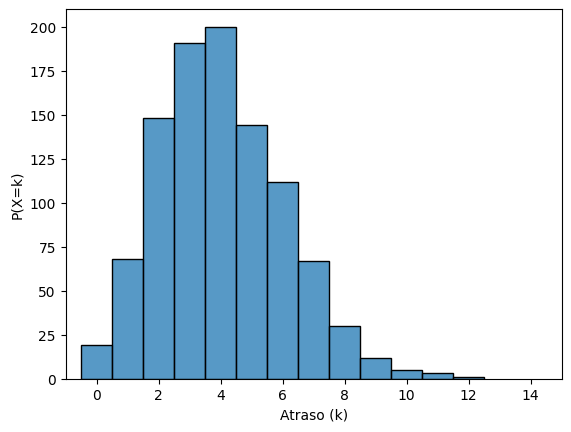

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

#atraso = poisson.rvs(mu=2, size=100, random_state=0)
atraso = [poisson.rvs(mu=4) for _ in range(1000)]
sns.histplot(atraso, discrete=True)
plt.xlim([-1,15])
plt.xlabel('Atraso (k)')
plt.ylabel('P(X=k)')
#atraso

In [9]:
print(max(atraso))

12


In [10]:
poisson.rvs(mu=2)

2

### **Classe Somn (*Ambiente SOMN*)**

In [11]:
from numpy.random.mtrand import seed
# a biblioteca gym mudou
import gymnasium as gym
from gymnasium import spaces  # Discrete, Box, Tuple,  Dict
from gymnasium import Env

# biblioteca stable_baselines3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
# from stable_baselines3 import PPO, A2C, DQN, DDPG, TD3

# outras bibliotecas
import os
import numpy as np
import random
import numpy as np
from absl import flags
from scipy.stats import poisson
import torch
import wandb


class Somn(Env):
    """Custom Environment that follows gym interface."""

    def __init__(
        self,
        M: int,
        N: int,
        Y: int,
        MAXDO: int,
        MAXAM: int,
        MAXPR: int,
        MAXPE: int,
        MAXFT: int,
        MAXMT: int,
        MAXTI: int,
        MAXEU: int,
        #seed: int
    ):
        super(Somn).__init__()



        #Somn.producing = 0
        Somn.time = 1
        self.M = M
        self.N = N
        self.Y = Y
        self.MAXDO = MAXDO
        self.MAXAM = MAXAM
        self.MAXPR = MAXPR
        self.MAXPE = MAXPE
        self.MAXFT = MAXFT
        self.MAXMT = MAXMT
        self.MAXTI = MAXTI
        self.MAXEU = MAXEU
        # self.MT = np.random.randint(0,MAXFT,M)
        self.EU = np.random.random(M) * MAXEU
        self.BA = np.random.randint(0, MAXFT, M)
        self.IN = np.random.randint(0, MAXFT, M)
        self.OU = np.random.randint(0, MAXFT, M)
        #self.seed = seed
        #self.atraso = atraso # (by_frederic)

        # self.state = np.zeros((N,5))

        # print('Inicializado', M, N , Y)

        self.DE = [
            Demand(
                M, N, MAXDO, MAXAM, MAXPR, MAXPE, MAXFT, MAXMT, MAXTI, MAXEU, Somn.time
            )
            for _ in range(N)
        ]
        self.YA = [Yard(Y, M, MAXFT) for _ in range(Y)]

        ######################
        #      lb e ub       #
        ######################
        """
        (lb=lowerbound ub=upperbound) para o espaco de Observacao e Acao 
        """

        # ST varia de -2 a 5
        self.lb_ST = -2
        self.ub_ST = 5
        # time varia de 1 a (10*MAXDO + M)
        self.lb_time = 1
        self.ub_time = 10 * self.MAXDO + self.M
        # LT varia de 2 a (M/2 + 2)
        self.lb_LT = 2
        self.ub_LT = int(self.M / 2) + 2
        # DO varia de 3 a (ub_time + ub_LT + MAXDO)
        self.lb_DO = 3
        self.ub_DO = self.ub_time + self.ub_LT + self.MAXDO

        # TP varia de 2 a (ub_time + ub_LT + 2) onde 2 e um ruido (troquei 2 pela distribuicao de poisson)
        self.lb_TP = 2
        atraso = [poisson.rvs(mu=self.ub_LT) for _ in range(10000)
                                                    ]
        self.ub_TP = self.ub_time + self.ub_LT + max(atraso)
        # MT varia de 0 a MAXFT
        self.lb_MT = np.array([0 for _ in range(self.M)]).astype(np.int64)
        self.ub_MT = np.array([MAXFT for _ in range(self.M)]).astype(np.int64)
        # EU varia de 0 a MAXEU
        self.lb_EU = np.array([0 for _ in range(self.M)]).astype(np.float64)
        self.ub_EU = np.array([MAXEU for _ in range(self.M)]).astype(np.float64)
        # BA varia de 0 a MAXFT
        self.lb_BA = np.array([0 for _ in range(self.M)]).astype(np.int64)
        self.ub_BA = np.array([MAXFT for _ in range(self.M)]).astype(np.int64)
        # IN varia de 0 a MAXFT
        self.lb_IN = np.array([0 for _ in range(self.M)]).astype(np.int64)
        self.ub_IN = np.array([MAXFT for _ in range(self.M)]).astype(np.int64)
        # OU varia de 0 a MAXFT
        self.lb_OU = np.array([0 for _ in range(self.M)]).astype(np.int64)
        self.ub_OU = np.array([MAXFT for _ in range(self.M)]).astype(np.int64)

        # lb e ub--- segunda versao (sem a coluna com os valores de Somn.time)
        # self.lb = np.array([[self.lb_ST, self.lb_LT, self.lb_DO, self.lb_TP] for _ in range(self.N)])
        # self.ub = np.array([[self.ub_ST, self.ub_LT, self.ub_DO, self.ub_TP] for _ in range(self.N)])

        # # lb e ub--- primeira versao (com a coluna com os valores de Somn.time)
        # self.lb = np.array([[self.lb_ST, self.lb_time, self.lb_LT, self.lb_DO, self.lb_TP] for _ in range(self.N)])
        # self.ub = np.array([[self.ub_ST, self.ub_time, self.ub_LT, self.ub_DO, self.ub_TP] for _ in range(self.N)])



        ######################
        #      Espacos       #
        ######################
        """
        Precisa mudar o espaco de acao 
        de acordo com o algoritmo utilizado
        """

        # accept to produce or reject
        # self.action_space = spaces.Box(0, 4, shape=(1,)) # usar o TD3
        self.action_space = spaces.Discrete(self.MAXDO)  # usar com o PPO, DQN, A2C

        # Espaco de observacao (como ficam as demandas depois da acao)
        # self.observation_space = spaces.Box(self.lb, self.ub, dtype=int)
        # self.observation_space = spaces.Dict({'tempo':spaces.Box(self.lb_time, self.ub_time, shape=(1,), dtype=int),
        #                                 'estado': spaces.Box(self.lb, self.ub, dtype=int)})      # versao para MultiInputPolicy
        # self.observation_space = spaces.Dict({'time':spaces.Box(self.lb_time, self.ub_time, shape=(1,), dtype=int),
        #                                'MT': spaces.Box(self.lb_MT, self.ub_MT, dtype=int),
        #                                'EU': spaces.Box(self.lb_EU, self.ub_EU, dtype=float),
        #                                'BA': spaces.Box(self.lb_BA, self.ub_BA, dtype=int),
        #                                'IN': spaces.Box(self.lb_IN, self.ub_IN, dtype=int),
        #                                'OU': spaces.Box(self.lb_OU, self.ub_OU, dtype=int),
        #                                'state': spaces.Box(self.lb, self.ub, dtype=int)})          # versao para MultiInputPolicy

        self.observation_space = spaces.Dict(
            {
                "time": spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float64),
                "MT": spaces.Box(low=0.0, high=1.0, shape=(self.M,), dtype=np.float64),
                "EU": spaces.Box(low=0.0, high=1.0, shape=(self.M,), dtype=np.float64),
                "BA": spaces.Box(low=0.0, high=1.0, shape=(self.M,), dtype=np.float64),
                "IN": spaces.Box(low=0.0, high=1.0, shape=(self.M,), dtype=np.float64),
                "OU": spaces.Box(low=0.0, high=1.0, shape=(self.M,), dtype=np.float64),
                "state": spaces.Box(
                    low=0.0, high=1.0, shape=(self.N, 4), dtype=np.float64
                ),
            }
        )  # versao para MultiInputPolicy Normalizada

    ######################
    #      funcoes       #
    ######################

    # recebe um atributo por exemplo 'LT' ou 'real_LT' e devolve os valores
    # de Lead Time das Demandas ou Real Lead Time, conforme o atributo passado.
    def get_Demands_Attr(env, atributo):
        d = [getattr(demandas, atributo) for demandas in env.DE]
        return d
        
    # Normaliza o valor dentro do range passado como parametro 
    def normaliza(self, x, min, max):
        x_norm = np.array((x - min) / (max - min)).astype(np.float64)
        return x_norm

    def readDemand(self):
        for i in range(Demand.N):
            if (
                self.DE[i].ST == -1
            ):  # or self.DE[i].ST == 0: ZERO não pode ser status de livre
                self.DE[i](Somn.time)

    def match_demand_with_inventory(self, limiar: float, t: int) -> bool:
        matched = False
        for i in range(Demand.N):
            for y in range(Yard.cont):
                match = 0
                # print('Y...', y, 'YA=', YA[y].yard,Yard.cont, 'l=', limiar)
                for j in range(Demand.M):
                    # print('Y(y,j):', y,j, 'Y x D:', self.YA[y].yard[j],self.DE[i].FT[j], 'cont:', Yard.cont, 'l x m:', limiar, match)
                    if self.DE[i].FT[j] > 0:
                        if self.DE[i].FT[j] <= self.YA[y].yard[j]:
                            match = match + 1
                    # se for ZERO então não pode ter a caracteristica
                    else:
                        if self.YA[y].yard[j] == 0:
                            match = match + 1

                if match >= limiar:
                    # print("\n Match: Casou", Yard.cont)
                    self.YA[y].yard = self.YA[Yard.cont - 1].yard  ## apaga o registro de match com o último da lista
                    Yard.cont -= 1
                    self.DE[i].ST = 3  ## produced status
                    matched = True

            # print("\n Match: Saiu", Yard.cont)
            return matched

    def product_scheduling(self, t: int, action):
        for i in range(self.N):
            if self.DE[i].ST == 1:
                if self.DE[i].DO > (t + self.DE[i].LT + action):
                    self.DE[i].ST = 3  ## produced status --- remember to run time for each case
                    self.OU -= self.DE[i].FT  ## CONSOME OS RECURSOS
                    ################################################
                    #                                              #
                    #                  atraso                      #
                    #                                              #
                    ################################################

                    #Somn.producing = min(self.M, Somn.producing + 1)
                    #Somn.producing = Somn.producing + 1
                    Demand.load += 1
                    #self.DE[i].TP = t + self.DE[i].LT + poisson.rvs(mu=2)
                    self.DE[i].real_LT = poisson.rvs(mu=self.DE[i].LT) # by_frederic
                    self.DE[i].TP = t + self.DE[i].real_LT
                    
                    # if self.atraso > 5:
                    #     self.DE[i].TP = t + self.DE[i].LT + poisson.rvs(mu=2)
                    # else:
                    #     self.DE[i].TP = t + self.DE[i].LT + self.atraso  # ruido  --- trocar por distribuição poison --- ou por algo que dependa de AM random.randint(1,Demand.MAXTI)
                    #     # print('\n **** PRODUCED because', self.DE[i].DO, '>', t + self.DE[i].LT + action)
                else:
                    #Somn.producing = max(0, Somn.producing - 1)
                    #Somn.producing = Somn.producing - 1
                    self.DE[i].ST = 2  ## rejected status
                    self.OU -= self.DE[i].FT  ### libera do buffer de produção
                    self.BA += self.DE[i].FT  ## devolve para o saldo para os próximos
                    # print('\n **** REJECTED by DO', self.DE[i].DO, ' <= DI+LT+act', t , self.DE[i].LT , action)

    def product_destination(self, t: int):
        for i in range(Demand.N):
            if self.DE[i].ST == 3:
                if self.DE[i].TP < t:  ### TP eh resultado de LT(#f) + RAND
                    #Somn.producing = Somn.producing - 1
                    Demand.load -= 1
                    if t < self.DE[i].DO:
                        self.DE[i].ST = 5  ## produced status --- remember to run time for each case
                        # print("\n Destination: Enviou", Yard.cont)
                    else:
                        self.DE[i].ST = 4  ## produced status
                        if Yard.cont < Yard.Y - 1:
                            self.YA[Yard.cont].yard = self.DE[i].FT
                            Yard.cont += 1
                            # print("\n Destination: Armazenou no YARD", Yard.cont)
                        else:
                            self.DE[i].ST = -2  ## NAO CABE ... REJEITADO COM GERAÇÃO DE LIXO (CASO MAIS GRAVE)

    def stock_covers_demand(self, t):
        covered = True

        for i in range(self.N):
            if self.DE[i].ST == 0:
                DF = self.BA - self.DE[i].FT

                OR = np.array(
                    [abs(i) if i < 0 else 0 for i in DF]
                )  # O QUE PRECISA SER COMPRADO
                # print('\n ORDER from ', DF, ':', OR)
                if not np.any(OR):
                    self.DE[i].ST = 1
                    self.BA -= np.array(DF)  ### ATUALIZA O SALDO
                    self.OU += np.array(DF)  ### ATUALIZA A SAÍDA
                    # print('\n balance:', self.BA,  'because not buying',self.OU)
                else:
                    covered = False
                    self.IN += np.array(OR)  ## ATUALIZA O TOTAL DE COMPRAVEIS
                    # print('\n balance: ', self.BA, 'because buying',OR, 'accumulating', self.IN)
        return covered

    # def order_raw_material(self, t: int):
    # self.IN = [random.randint(0,i) if i > 0 else 0 for i in self.IN]
    # return self.IN

    def eval_final_states(self) -> float:
        totProfit = 0.0
        totReward = 0.0
        totPenalty = 0.0
        for i in range(self.N):
            if self.DE[i].ST == 2:
                self.DE[i].ST = -1  # LIBERA O ESPAÇO APÓS CONTABILIZADO
                totProfit += self.DE[i].AM * self.DE[i].PR
                # print('REJECTED vvvvvvvvvvvvvvvvvvvvvvvvvvvv')
            if self.DE[i].ST == -2:
                totPenalty += self.DE[i].CO
                self.DE[i].ST = -1  # LIBERA O ESPAÇO APÓS CONTABILIZADO
                # print('PREJUIZO $$$$$$$$$$$$$$$$$$$$$$$$$')
            if self.DE[i].ST == 4:
                totPenalty += totReward / (
                    Yard.space - Yard.cont + 1
                )  ### penalidade inversamente proporcional ao espaço remanescente
                self.DE[i].ST = -1  # LIBERA O ESPAÇO APÓS CONTABILIZADO
                totProfit += self.DE[i].AM * self.DE[i].PR
                # print('STORED <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
            if self.DE[i].ST == 5:
                totReward += self.DE[i].AM * self.DE[i].PR
                self.DE[i].ST = -1  # LIBERA O ESPAÇO APÓS CONTABILIZADO
                totProfit += self.DE[i].AM * self.DE[i].PR
                # print('REWARD ******************************')
        totReward -= totPenalty
        # print ('REW+PEN+PRO', totReward, totPenalty, totProfit)
        return totReward, totPenalty, totProfit

    ######################
    #       step         #
    ######################

    def step(self, action):
        """
        Atualiza tudo aqui e devolve o próximo estado: n_state, reward, done, info

            - n_state: próximo estado; 
            - reward: recompensa da ação; 
            - done: flag de conclusão; 
            - info: informaões extras (opcional)

        Primeira versão vai fazer uma iteração para cada episódio ... 
        O Tempo t precisa ser controlado
        """

        # receive RAW MATERIAL AND ORDERS (DEMANDS)
        self.MT = np.array([random.randint(0, i) if i > 0 else 0 for i in self.IN])
        self.readDemand()

        # IF PREVIOUS ORDERS INVENTORY AVAILABLE, PLEASE DISPATCH
        if self.match_demand_with_inventory(self.MAXFT / 5, Somn.time):
            self.product_destination(Somn.time)

        # ANYWAY, UPDATE BALANCE AND INCOME RAW MATERIAL REGARDING MT RECEIVED
        self.IN -= self.MT
        self.BA += self.MT

        # IF RAW MATERIAL INVENTORY DOES NOT COVER PLEASE REQUEST RAW MATERIAL
        if not self.stock_covers_demand(Somn.time):
            self.IN = np.array(
                [random.randint(0, i) if i > 0 else 0 for i in self.IN]
            ).astype(np.int64)

        # ANYWAY START PRODUCING AND DISPATCHING
        self.product_scheduling(Somn.time, action)
        self.product_destination(Somn.time)
        Somn.time += 1

        # ORDINARY PROCEDURES IN STEP METHOD INCLUDING REWARD BY INSPECTING FINAL STATES
        # 1 STATE
        arrayState = []

        for i in range(self.N):
            aux_row = [
                self.normaliza(x=self.DE[i].ST, min=self.lb_ST, max=self.ub_ST),
                # Somn.time,
                # self.DE[i].SP,
                self.normaliza(self.DE[i].LT, self.lb_LT, self.ub_LT),
                # self.DE[i].VA,
                # self.DE[i].SU,
                # self.DE[i].PR,
                self.normaliza(self.DE[i].DO, self.lb_DO, self.ub_DO),
                self.normaliza(self.DE[i].TP, self.lb_TP, self.ub_TP),
            ]
            arrayState.append(aux_row)

        self.state = np.array(arrayState)

        # 2 REWARD
        (
            reward,
            penalty,
            exprofit,
        ) = self.eval_final_states()  # aqui vai a função que calcula a recompensa

        # Gera grafico do Yard (by_frederic)


        # 3 FINAL CONDITION
        done = False
        truncated = False
        # if penalty>0:
        # reward =0
        # print('\n D -- O -- N -- E --', self.state)
        # done = True

        if Somn.time >= self.ub_time:  # 10*Demand.MAXDO + Demand.M   (TEMPOMAX)
            # print('\n D -- O -- N -- E --', self.state)
            done = True

        # Atualiza o upper bounds

        self.ub_MT = max(self.MAXFT, np.amax(self.MT))
        self.ub_BA = max(self.MAXFT, np.amax(self.BA))
        self.ub_IN = max(self.MAXFT, np.amax(self.IN))

        info = {}  # Informações adicionais
        # observation = self.state  #by_frederic: retorna quando e um tipo Box
        observation = {
            "time": np.array([self.normaliza(self.time, self.lb_time, self.ub_time)]),
            "MT": self.normaliza(self.MT, self.lb_MT, self.ub_MT),
            "EU": self.normaliza(self.EU, self.lb_EU, self.ub_EU),
            "BA": self.normaliza(self.BA, self.lb_BA, self.ub_BA),
            "IN": self.normaliza(self.IN, self.lb_IN, self.ub_IN),
            "OU": self.normaliza(self.OU, self.lb_OU, self.ub_OU),
            "state": self.state,
        }  # by_frederic: retorna quando e um tipo Dict

        return (
            observation,
            reward,
            done,
            truncated,
            info,
        )  # , exprofit   # by_frederic:

    ######################
    #       reset        #
    ######################

    def reset(self):
        #super().reset(seed=seed)
        self.MT = np.random.randint(0, self.MAXFT, self.M)
        self.EU = np.random.random(self.M) * self.MAXEU
        self.BA = np.random.randint(0, self.MAXFT, self.M)
        self.IN = np.random.randint(0, self.MAXFT, self.M)
        self.OU = np.random.randint(0, self.MAXFT, self.M)
        Somn.time = 1

        self.YA = [Yard(self.Y, self.M, self.MAXFT) for _ in range(self.Y)]

        arrayState = []
        for i in range(self.N):
            self.DE[i](Somn.time)
            aux_row = [
                self.normaliza(x=self.DE[i].ST, min=self.lb_ST, max=self.ub_ST),
                # Somn.time,
                # self.DE[i].SP,
                self.normaliza(x=self.DE[i].LT, min=self.lb_LT, max=self.ub_LT),
                # self.DE[i].VA,
                # self.DE[i].SU,
                # self.DE[i].PR,
                self.normaliza(x=self.DE[i].DO, min=self.lb_DO, max=self.ub_DO),
                self.normaliza(x=self.DE[i].TP, min=self.lb_TP, max=self.ub_TP),
            ]
            arrayState.append(aux_row)

        self.state = np.array(arrayState)

        info = dict()
        # observation = (self.state, info)  # by_frederic: retorna quando o tipo é Box
        observation = {
            "time": np.array([self.normaliza(self.time, self.lb_time, self.ub_time)]),
            "MT": self.normaliza(self.MT, self.lb_MT, self.ub_MT),
            "EU": self.normaliza(self.EU, self.lb_EU, self.ub_EU),
            "BA": self.normaliza(self.BA, self.lb_BA, self.ub_BA),
            "IN": self.normaliza(self.IN, self.lb_IN, self.ub_IN),
            "OU": self.normaliza(self.OU, self.lb_OU, self.ub_OU),
            "state": self.state,
        }  # by_frederic: retorna quando e um tipo Dict

        return (observation, info)  # by_frederic: para se adequar ao Gymnasium

    ######################
    #       render       #
    ######################

    def render(self):
        # print("Current state (RENDER): \n", self.state)
        pass

    ######################
    #       close        #
    ######################

    def close(self):
        pass


/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


## **Sweep para Hiperparametrização**

### Parametros

In [ ]:
config = {
    #'method': 'bayes'
    'method': 'random'
    }

In [ ]:
metric = {
    'name': 'mean_reward_test',
    'goal': 'maximize'   
    }

config['metric'] = metric

In [ ]:
parameters_dict = {
    'batch_size': {
        'values': [16, 32, 64, 128, 256]       
      },
    # 'clip_range': {
    #     'values': [0.1, 0.2, 0.3]
    #     },
    'ent_coef': {
        'distribution': 'uniform',
        'max': 0.01,
        'min': 0
    },
    'gae_lambda': {
        'distribution': 'uniform',
        'max': 1,
        'min': 0.9
    },
    'gamma': {
        'distribution': 'uniform',
        'max': 1,
        'min': 0.8
    },
    'learning_rate': {
        'distribution': 'uniform',
        'max': 0.0009,
        'min': 1e-05
    },
    # 'max_grad_norm': {
    #     'distribution': 'uniform',
    #     'max': 1,
    #     'min': 0.5
    # },
    'n_epochs': {
        'distribution': 'int_uniform',
        'max': 30,
        'min': 5
    },
    'n_steps': {
        'values': [1024, 1536, 2048, 2304, 2560, 2816, 3072, 3328, 3584, 3840, 4096]
    },
    # 'stats_window_size': {
    #     'distribution': 'int_uniform',
    #     'max': 200,
    #     'min': 50
    # },
    'target_kl': {
        'distribution': 'uniform',
        'max': 0.03,
        'min': 0.003
    },
    # 'total_timesteps': {
    #     'distribution': 'uniform',
    #     'max': 2000000,
    #     'min': 50000
    # },
    # 'vf_coef': {
    #     'distribution': 'uniform',
    #     'max': 1,
    #     'min': 0.5
    #}
}

config['parameters'] = parameters_dict

### Print Parametros

In [ ]:
import pprint

pprint.pprint(config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'mean_reward_test'},
 'parameters': {'batch_size': {'values': [16, 32, 64, 128, 256]},
                'ent_coef': {'distribution': 'uniform', 'max': 0.01, 'min': 0},
                'gae_lambda': {'distribution': 'uniform', 'max': 1, 'min': 0.9},
                'gamma': {'distribution': 'uniform', 'max': 1, 'min': 0.8},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.0009,
                                  'min': 1e-05},
                'n_epochs': {'distribution': 'int_uniform',
                             'max': 30,
                             'min': 5},
                'n_steps': {'values': [1024,
                                       1536,
                                       2048,
                                       2304,
                                       2560,
                                       2816,
                                       3072,
 

### Inicializar o Sweep

In [ ]:
sweep_id = wandb.sweep(config, project="Somn_02")

Create sweep with ID: ynaffmsm
Sweep URL: https://wandb.ai/lacmor/Somn_02/sweeps/ynaffmsm


In [ ]:
sweep_id = 'y4lr9j62'

### Funcao treinamento1

obs: criar a pasta dentro do drive /content/drive/MyDrive/SOMN2

In [ ]:
import wandb
#import gym

#from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder

#from wandb.integration.sb3 import WandbCallback

def make_env():
    env = Somn(Y=10,M=5,N=7,MAXDO=10,MAXAM=5,MAXPR=1.5,MAXPE=10,MAXFT=5,MAXMT=3,MAXTI=2,MAXEU = 10)
    env = Monitor(env)  # record stats such as returns
    return env

def treinamento1(config=None):
    # Initialize a new wandb run
    if len(wandb.patched["tensorboard"]) > 0:
        wandb.tensorboard.unpatch()
    #wandb.tensorboard.patch(root_logdir="/content/drive/MyDrive/SOMN2/runs")
    wandb.tensorboard.patch(root_logdir="./runs")
    run1 = wandb.init(project='Somn_02', config=config, save_code=True)
    #project="Somn_01",
    #config=config,
    #sync_tensorboard=False,  # auto-upload sb3's tensorboard metrics
    #monitor_gym=True,  # auto-upload the videos of agents playing the game
    #save_code=True,  # optional
    #) as run:
    # settings=wandb.Settings(start_method="thread")
    # ) as run:

    # If called by wandb.agent, as below,
    # this config will be set by Sweep Controller
    config = wandb.config
    env1 = DummyVecEnv([make_env])
    

    # algoritmos = [PPO, RecurrentPPO]
    # politica ={PPO: "MultiInputPolicy", RecurrentPPO: "MlpLstmPolicy"}
    
        
    model1 = PPO(
        policy="MultiInputPolicy", 
        env=env1, 
        learning_rate=config.learning_rate, 
        n_steps=config.n_steps, 
        batch_size=config.batch_size, 
        n_epochs=config.n_epochs, 
        gamma=config.gamma, 
        gae_lambda=config.gae_lambda, 
        #clip_range=config.clip_range, 
        ent_coef=config.ent_coef,
        #vf_coef=config.vf_coef, 
        #max_grad_norm=config.max_grad_norm,
        target_kl=config.target_kl,
        #stats_window_size=config.stats_window_size, 
        verbose=0, 
        #seed = 2023,
        device='cpu',
        #tensorboard_log=f"/content/drive/MyDrive/SOMN2/runs/{run1.id}"
        tensorboard_log=f"runs/{run1.id}"
    )

    model1.learn(total_timesteps=1000000)
    wandb.finish()

### Funcao treinamento2

In [ ]:
import wandb
#import gym

#from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder

#from wandb.integration.sb3 import WandbCallback

# def make_env():
#     env = Somn(Y=10,M=5,N=7,MAXDO=10,MAXAM=5,MAXPR=1.5,MAXPE=10,MAXFT=5,MAXMT=3,MAXTI=2,MAXEU = 10)
#     env = Monitor(env)  # record stats such as returns
#     return env

def treinamento2(config=None):
    # Initialize a new wandb run
    if len(wandb.patched["tensorboard"]) > 0:
        wandb.tensorboard.unpatch()
    #wandb.tensorboard.patch(root_logdir="/content/drive/MyDrive/SOMN2/runs")
    wandb.tensorboard.patch(root_logdir="./runs")
    run2 = wandb.init(project='Somn_02', config=config, save_code=True)
    #project="Somn_01",
    #config=config,
    #sync_tensorboard=False,  # auto-upload sb3's tensorboard metrics
    #monitor_gym=True,  # auto-upload the videos of agents playing the game
    #save_code=True,  # optional
    #) as run:
    # settings=wandb.Settings(start_method="thread")
    # ) as run:

    # If called by wandb.agent, as below,
    # this config will be set by Sweep Controller
    config = wandb.config
    env2 = DummyVecEnv([make_env])
    

    # algoritmos = [PPO, RecurrentPPO]
    # politica ={PPO: "MultiInputPolicy", RecurrentPPO: "MlpLstmPolicy"}
    
        

    model2 = RecurrentPPO(
        policy="MultiInputLstmPolicy", 
        env=env2, 
        learning_rate=config.learning_rate, 
        n_steps=config.n_steps, 
        batch_size=config.batch_size, 
        n_epochs=config.n_epochs, 
        gamma=config.gamma, 
        gae_lambda=config.gae_lambda, 
        #clip_range=config.clip_range, 
        ent_coef=config.ent_coef,
        #vf_coef=config.vf_coef, 
        #max_grad_norm=config.max_grad_norm,
        target_kl=config.target_kl,
        #stats_window_size=config.stats_window_size, 
        verbose=0, 
        #seed = 2023,
        device='cuda',
        #tensorboard_log=f"/content/drive/MyDrive/SOMN2/runs/{run2.id}"
        tensorboard_log=f"runs/{run2.id}"
    )

    model2.learn(total_timesteps=1000000)
    wandb.finish()


### Executar o agente do Sweep

#### Seed

In [ ]:
import random
import numpy as np
import torch as th

SEED = 1

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    #th.manual_seed(seed)
    #th.cuda.manual_seed(seed)
    #th.backends.cudnn.deterministic = True
    #env.seed(seed)

##One call at beginning is enough
seed_everything(SEED)

#### Iniciando o Agente

A célula abaixo lançará um `agente` que executa `treinamento1` e `treinamento2` 20 vezes, usando os valores de hiperparâmetro gerados aleatoriamente retornados pelo controlador de varredura. A execução leva um tempo razoavelmente alto.

In [ ]:
wandb.agent(sweep_id, treinamento2, count=20)
#wandb.agent(sweep_id, treinamento1, count=10)

wandb: Agent Starting Run: fhy4jpzy with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: 0.005788219044377244
wandb: 	gae_lambda: 0.9979891025722388
wandb: 	gamma: 0.8270118591537439
wandb: 	learning_rate: 0.0006135570772713557
wandb: 	n_epochs: 8
wandb: 	n_steps: 4096
wandb: 	target_kl: 0.02375670972140671
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Actions,█▅▄▃▂▂▁▂▁▂▂▂▁▁▂▂▂▁▁▁▂▁▁▁▁▁▂▂▁▁▁▂▂▃▁▁▁▂▂▂
Lead Time,▆▆▆▃▆▄█▄▄▆█▆█▆▄▆▁▆▄▆▄▄█▁▃█▄▆█▁▄█▆▃▄█▆▆█▆
Lead Time Variation,▃▄▁▂▁▂▅▄▃▆▅█▂▄▂▄▇▃▅█▅▆▃▇▂▆▃▄▇▅▃▃▄▃▆▄▂▄▅▃
Load,█████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Real Lead Time,▃▄▁▂▁▂▅▃▂▆▅█▃▄▂▄▆▃▄█▄▅▄▆▁▆▃▄▇▄▂▃▄▂▆▄▂▄▅▃
Yard,▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁███▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
approx_kl,▂▂▂▂▁▁▁▂▁▂▁▄▁▁▁▁▂▁▂▂▂▂▂▂▂▁█▃▂▁▃▃▂▃▁▂▂▃▂▃
clip_fraction,▇▁▃▂▃▂▃▄▃▄▃▅▃▂▁▃▃▃▂▄▃▂▁▃▃▁▂▃▄▁▃▇▄▄▃▆▃▇▇█
entropy_loss,▁▂▃▅▅▆▇▇▇▇▇▇▇████▇█▇███████████▇▇▇█▇▇▇▆▆
ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
explained_variance,▁▆▆▆▇▆▆▆▆▇▇█▇▇▇▇█▆▆▇▆▆▇▇▆▆▅▇▇▇▆█▆█▇▅▆▇▇▇


wandb: Agent Starting Run: mqjgwa3m with config:
wandb: 	batch_size: 128
wandb: 	ent_coef: 0.000677242623529355
wandb: 	gae_lambda: 0.9096063272689908
wandb: 	gamma: 0.9039747034700276
wandb: 	learning_rate: 0.000711522017187105
wandb: 	n_epochs: 11
wandb: 	n_steps: 3840
wandb: 	target_kl: 0.02538491807734933
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Actions,█▅▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▂▁▂▁▃▁▂▃▁▁▁▁▁▂▁▁▁▁▁▂▁▁
Lead Time,█▃██▃██▃▃███▆▃██▁▆▁▆▆█▆▆█▁█▆▃▆▁██▃▃▁▃▆█▁
Lead Time Variation,▃█▆▃▅▂▃▁▃▁▃▆▃▇▂▂▇▅▃▃▄▆▅▇▃▄▆▄▃▂▄▄▅▅▃▄▅▅▅▃
Load,█████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Real Lead Time,▃█▆▄▅▃▄▁▃▂▄▆▃▇▃▂▆▅▃▄▄▆▅▇▄▄▆▄▃▂▄▄▅▅▃▄▅▆▅▃
Yard,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█▁▁█▁▁
approx_kl,▃▃▂▃▂▁▂▂▂▂▂▁▂▃▂▂▁▁▂▁█▁▇▁▃▄▃▂▆▁▁▂▂▄▄▁▂▃▁▁
clip_fraction,▅█▆▅▅▂▃▂▅▃▃▂▃▂▂▂▁▁▂▁▃▁▂▁▂▂▁▁▁▁▁▂▂▂▃▂▂▂▁▁
entropy_loss,▁▂▄▅▆▆▇▇▆▇▇▇▇▇▇██████████████████▇▇█████
ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
explained_variance,▁▅▇▆▇█▇▇▇▇▆▇▇▇▇███▇▇▆▇▇▆▇█▆█▇█▇▇▇▇▇▇▇███


wandb: Agent Starting Run: u8e75feu with config:
wandb: 	batch_size: 128
wandb: 	ent_coef: 0.004268816725714917
wandb: 	gae_lambda: 0.9906640452143494
wandb: 	gamma: 0.8321713162675248
wandb: 	learning_rate: 0.0008132541801234868
wandb: 	n_epochs: 7
wandb: 	n_steps: 3584
wandb: 	target_kl: 0.022143741883167457
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Ctrl + C detected. Stopping sweep.


## **Sweep para Treinamento com os melhores parametros**

### Parametros PPO

In [ ]:
config1 = {
    'method': 'grid'
    }

In [ ]:
metric = {
    'name': 'mean_reward_test',
    'goal': 'maximize'   
    }

config1['metric'] = metric

In [ ]:
parameters_dict = {
    'batch_size': {
        'value': 256       
      },
    # 'clip_range': {
    #     'values': [0.1, 0.2, 0.3]
    #     },
    'ent_coef': {
        'value': 0.001641577520175419
    },
    'gae_lambda': {
        'value': 0.9142950466044
    },
    'gamma': {
        'value': 0.918623650457886
    },
    'learning_rate': {
        'value': 0.0003660144793262825
    },
    # 'max_grad_norm': {
    #     'distribution': 'uniform',
    #     'max': 1,
    #     'min': 0.5
    # },
    'n_epochs': {
        'value': 21
    },
    'n_steps': {
        'value': 3328
    },
    # 'stats_window_size': {
    #     'distribution': 'int_uniform',
    #     'max': 200,
    #     'min': 50
    # },
    'target_kl': {
        'value' : 0.02113910446426361

    },
    # 'total_timesteps': {
    #     'distribution': 'uniform',
    #     'max': 2000000,
    #     'min': 50000
    # },
    # 'vf_coef': {
    #     'distribution': 'uniform',
    #     'max': 1,
    #     'min': 0.5
    #}
}

config1['parameters'] = parameters_dict

### Parametros Recurrent PPO

In [ ]:
config2 = {
    'method': 'grid'
    }

In [ ]:
metric = {
    'name': 'mean_reward_test',
    'goal': 'maximize'   
    }

config2['metric'] = metric

In [ ]:
parameters_dict = {
    'batch_size': {
        'value': 256       
      },
    # 'clip_range': {
    #     'values': [0.1, 0.2, 0.3]
    #     },
    'ent_coef': {
        'value': 0.0008191636368570355
    },
    'gae_lambda': {
        'value': 0.9536184702812897
    },
    'gamma': {
        'value': 0.8332421508315541
    },
    'learning_rate': {
        'value': 0.00011266531568974308
    },
    # 'max_grad_norm': {
    #     'distribution': 'uniform',
    #     'max': 1,
    #     'min': 0.5
    # },
    'n_epochs': {
        'value': 17
    },
    'n_steps': {
        'value': 2048
    },
    # 'stats_window_size': {
    #     'distribution': 'int_uniform',
    #     'max': 200,
    #     'min': 50
    # },
    'target_kl': {
        'value' : 0.028836888292401667

    },
    # 'total_timesteps': {
    #     'distribution': 'uniform',
    #     'max': 2000000,
    #     'min': 50000
    # },
    # 'vf_coef': {
    #     'distribution': 'uniform',
    #     'max': 1,
    #     'min': 0.5
    #}
}

config2['parameters'] = parameters_dict

### Print Parametros

In [ ]:
import pprint

pprint.pprint(config2)
#pprint.pprint(config1)

{'method': 'grid',
 'metric': {'goal': 'maximize', 'name': 'mean_reward_test'},
 'parameters': {'batch_size': {'value': 256},
                'ent_coef': {'value': 0.0008191636368570355},
                'gae_lambda': {'value': 0.9536184702812897},
                'gamma': {'value': 0.8332421508315541},
                'learning_rate': {'value': 0.00011266531568974308},
                'n_epochs': {'value': 17},
                'n_steps': {'value': 2048},
                'target_kl': {'value': 0.028836888292401667}}}


### Inicializar o Sweep

In [ ]:
config = config2
config = config1
sweep_id = wandb.sweep(config, project="Somn_02")

Create sweep with ID: tetjkmyb
Sweep URL: https://wandb.ai/lacmor/Somn_02/sweeps/tetjkmyb


In [ ]:
#sweep_id = 'y4lr9j62'
sweep_id = 'tetjkmyb'

### Funcao treinamento1

obs: criar a pasta dentro do drive /content/drive/MyDrive/SOMN2

In [ ]:
import os
import wandb
#import gym

#from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder

#from wandb.integration.sb3 import WandbCallback

def make_env():
    env = Somn(Y=10,M=5,N=7,MAXDO=10,MAXAM=5,MAXPR=1.5,MAXPE=10,MAXFT=5,MAXMT=3,MAXTI=2,MAXEU = 10)
    env = Monitor(env)  # record stats such as returns
    return env

def treinamento1(config=None):
    # Initialize a new wandb run
    if len(wandb.patched["tensorboard"]) > 0:
        wandb.tensorboard.unpatch()
    #wandb.tensorboard.patch(root_logdir="/content/drive/MyDrive/SOMN2/runs")
    wandb.tensorboard.patch(root_logdir="./runs")
    run1 = wandb.init(project='Somn_02', config=config, save_code=True)
    #project="Somn_01",
    #config=config,
    #sync_tensorboard=False,  # auto-upload sb3's tensorboard metrics
    #monitor_gym=True,  # auto-upload the videos of agents playing the game
    #save_code=True,  # optional
    #) as run:
    # settings=wandb.Settings(start_method="thread")
    # ) as run:

    # If called by wandb.agent, as below,
    # this config will be set by Sweep Controller
    config = wandb.config
    env1 = DummyVecEnv([make_env])
    

    # algoritmos = [PPO, RecurrentPPO]
    # politica ={PPO: "MultiInputPolicy", RecurrentPPO: "MlpLstmPolicy"}
    
        
    model1 = PPO(
        policy="MultiInputPolicy", 
        env=env1, 
        learning_rate=config.learning_rate, 
        n_steps=config.n_steps, 
        batch_size=config.batch_size, 
        n_epochs=config.n_epochs, 
        gamma=config.gamma, 
        gae_lambda=config.gae_lambda, 
        #clip_range=config.clip_range, 
        ent_coef=config.ent_coef,
        #vf_coef=config.vf_coef, 
        #max_grad_norm=config.max_grad_norm,
        target_kl=config.target_kl,
        #stats_window_size=config.stats_window_size, 
        verbose=0, 
        #seed = 2023,
        device='cpu',
        #tensorboard_log=f"/content/drive/MyDrive/SOMN2/runs/{run1.id}"
        tensorboard_log=f"runs/{run1.id}"
    )

    model1.learn(total_timesteps=1000000)
    model1.save(os.path.join(wandb.run.dir, "model.h5"))
    wandb.finish()

### Funcao treinamento2

In [ ]:
import os
import wandb
#import gym

#from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder

#from wandb.integration.sb3 import WandbCallback

# def make_env():
#     env = Somn(Y=10,M=5,N=7,MAXDO=10,MAXAM=5,MAXPR=1.5,MAXPE=10,MAXFT=5,MAXMT=3,MAXTI=2,MAXEU = 10)
#     env = Monitor(env)  # record stats such as returns
#     return env

def treinamento2(config=None):
    # Initialize a new wandb run
    if len(wandb.patched["tensorboard"]) > 0:
        wandb.tensorboard.unpatch()
    #wandb.tensorboard.patch(root_logdir="/content/drive/MyDrive/SOMN2/runs")
    wandb.tensorboard.patch(root_logdir="./runs")
    run2 = wandb.init(project='Somn_02', config=config, save_code=True)
    #project="Somn_01",
    #config=config,
    #sync_tensorboard=False,  # auto-upload sb3's tensorboard metrics
    #monitor_gym=True,  # auto-upload the videos of agents playing the game
    #save_code=True,  # optional
    #) as run:
    # settings=wandb.Settings(start_method="thread")
    # ) as run:

    # If called by wandb.agent, as below,
    # this config will be set by Sweep Controller
    config = wandb.config
    env2 = DummyVecEnv([make_env])
    

    # algoritmos = [PPO, RecurrentPPO]
    # politica ={PPO: "MultiInputPolicy", RecurrentPPO: "MlpLstmPolicy"}
    
        

    model2 = RecurrentPPO(
        policy="MultiInputLstmPolicy", 
        env=env2, 
        learning_rate=config.learning_rate, 
        n_steps=config.n_steps, 
        batch_size=config.batch_size, 
        n_epochs=config.n_epochs, 
        gamma=config.gamma, 
        gae_lambda=config.gae_lambda, 
        #clip_range=config.clip_range, 
        ent_coef=config.ent_coef,
        #vf_coef=config.vf_coef, 
        #max_grad_norm=config.max_grad_norm,
        target_kl=config.target_kl,
        #stats_window_size=config.stats_window_size, 
        verbose=0, 
        #seed = 2023,
        device='cuda',
        #tensorboard_log=f"/content/drive/MyDrive/SOMN2/runs/{run2.id}"
        tensorboard_log=f"runs/{run2.id}"
    )

    model2.learn(total_timesteps=1000000)
    model2.save(os.path.join(wandb.run.dir, "model.h5"))
    wandb.finish()


### Executar o agente do Sweep

#### Seed

In [ ]:
import random
import numpy as np
import torch as th

SEED = 1

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    #th.manual_seed(seed)
    #th.cuda.manual_seed(seed)
    #th.backends.cudnn.deterministic = True
    #env.seed(seed)

##One call at beginning is enough
seed_everything(SEED)

#### Iniciando o Agente

A célula abaixo lançará um `agente` que executa `treinamento1` e `treinamento2` 20 vezes, usando os valores de hiperparâmetro gerados aleatoriamente retornados pelo controlador de varredura. A execução leva um tempo razoavelmente alto.

In [ ]:
#wandb.agent(sweep_id, treinamento2, count=5)
wandb.agent(sweep_id, treinamento1, count=5)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: While tearing down the service manager. The following error has occurred: [Errno 32] Broken pipe
wandb: Agent Starting Run: 4hki1w8v with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: 0.001641577520175419
wandb: 	gae_lambda: 0.9142950466044
wandb: 	gamma: 0.918623650457886
wandb: 	learning_rate: 0.0003660144793262825
wandb: 	n_epochs: 21
wandb: 	n_steps: 3328
wandb: 	target_kl: 0.02113910446426361
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Actions,█▆▃▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁
Lead Time,▄▂▄▇▂▄▄▄▂▅▅▇█▅▇▅▅▇█▄▂▅▅▇▂▇▁▅▅▇▂▅▇▄▄▅▇█▄▅
Lead Time Variation,▆▇▄▃▃██▇▄▇▄▃▆▇▃▅▇▅▆▆▂█▁▅▇▄▇█▅▆▆▅▇▆▃▄▆▆▄█
Load,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Real Lead Time,▅▇▄▄▂▇▇▆▄▇▄▃▆▇▃▅▇▆▇▅▂█▁▅▆▅▆█▅▇▆▅▇▅▃▄▇▇▄█
Yard,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
approx_kl,█▆▃▃▂▁▃▁▃▂▂▂▃▃▂▂▁▂▂▂▃▂▃▂▁▄▃▅▃▄▅▄▄▆▄▃▃▃▄▆
clip_fraction,█▄▃▃▂▁▂▂▄▂▂▃▃▃▃▃▁▂▂▄▃▃▃▃▂▄▄▅▄▅▅▅▅▅▄▄▄▃▅▆
entropy_loss,▁▂▄▆▆▇▇▇▇▇▇▇▇▇███████████▇█▇▇▇▇▇▇▇▇███▇▇
ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
explained_variance,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇████▇


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
